# Notebook for parsing BIST stock data

Possible sources: 
1. **Oyak Yatırım API**: 
  * `code`: stock code (TUKAS, CRDFA etc.)
  * `mode`:
    * 0: last day
    * 1: last week
    * 2: last month
    * 3: last year
    * 4: last 5 years
  * example: [TUKAS 5 YRS](https://www.oyakyatirim.com.tr/Equity/GetHistoricalEquityData?mode=4&code=TUKAS)

In [189]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import datetime
from sklearn.metrics import confusion_matrix
from scipy.stats import kurtosis, skew

In [190]:
# seconds to date format

def secs_to_date(secs):
    return datetime.datetime.fromtimestamp(secs/1000)
    
def dateify(x):
    return datetime.datetime.fromtimestamp(x/1000).strftime("%Y.%m.%d %I:%M")

In [191]:
def get_oyak_data(code, mode=2, verbose=True):
    
    # mode
    # 0 : past day
    # 1 : past week
    # 2 : past month
    # 3 : past year
    # 4 : past 5 yrs
    
    if 0 > mode or mode > 4:
        return [[],[]]
    
    r = requests.get(f"https://www.oyakyatirim.com.tr/Equity/GetHistoricalEquityData?mode={mode}&code={code}")
    
    series = np.array(eval(r.text))
    
    if verbose:
        print(f"{len(series)} datapoints returned by the API")
    
    return series

In [192]:
def get_dates_vals(series):
    dates = [ dateify(seconds) for seconds in series[:,0] ]
    vals  = series[:,1]
    return dates, vals

In [193]:
def plot_series(code, dates, values):
    plt.figure(figsize=(16,9))
    plt.plot(dates, values)
    plt.xticks(dates[::int(len(dates)/10)], rotation=45)
    #plt.xlabel('date')
    plt.ylabel('price (TRY)')
    plt.title(f'BIST {code} historical data')
    plt.grid()

# Parsing and viewing the data

Using oyak yatırım's API

In [194]:
code        = 'GARAN'

series      = get_oyak_data(code, 3)

dates, vals = get_dates_vals(series)

251 datapoints returned by the API


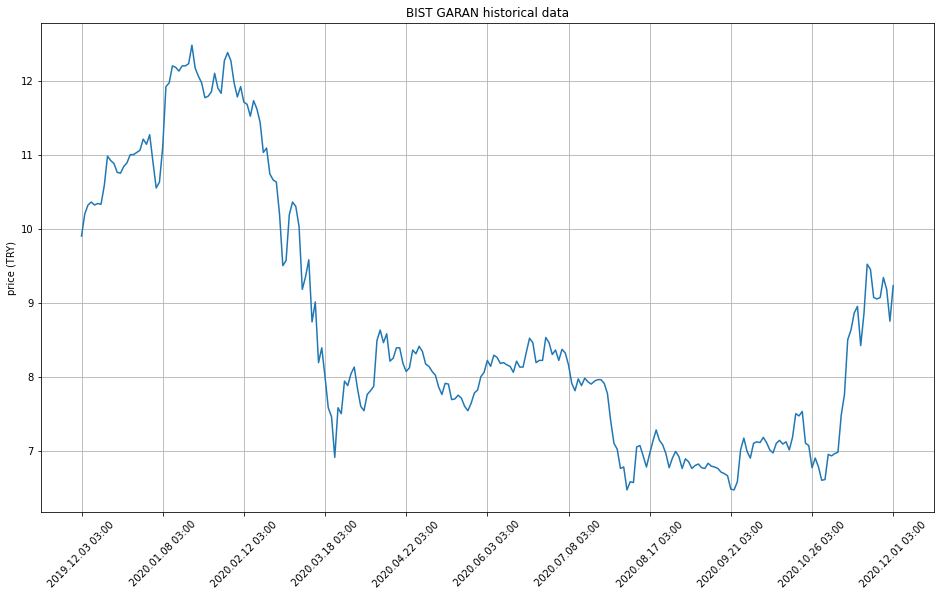

In [195]:
plot_series(code, dates, vals)

# Luckily we have last year's BIST data in our hands

In [196]:
df = pd.read_csv('data/stock/bist-stocks.csv', '\t')

In [197]:
df

,DATE,AFYON,AKBNK,AKSA,AKSEN,ALGYO,ALARK,ALBRK,AEFES,ANELE,...,TCELL,HALKB,ISCTR,ULKER,VAKBN,VERUS,VESTL,YKBNK,YATAS,ZOREN
0,1575331200000,1.97,7.64,6.34,3.78,14.70,5.28,1.20,20.36,3.02,...,13.02,5.78,6.06,21.50,5.09,17.59,11.49,2.40,6.45,1.41
1,1575417600000,1.96,7.71,6.38,3.82,14.79,5.33,1.21,19.91,3.07,...,13.18,5.80,6.17,21.46,5.20,17.72,11.73,2.40,6.47,1.47
2,1575504000000,2.04,7.76,6.36,3.84,15.15,5.44,1.24,19.86,3.08,...,13.50,5.93,6.25,21.90,5.24,17.84,11.80,2.45,6.88,1.48
3,1575590400000,2.05,7.77,6.56,3.81,15.27,5.41,1.29,20.08,3.11,...,13.52,5.87,6.20,21.72,5.10,17.99,12.15,2.47,6.47,1.47
4,1575849600000,2.09,7.67,6.70,3.89,15.23,5.34,1.31,20.08,3.13,...,13.22,5.80,6.13,21.36,5.12,18.15,12.26,2.46,6.54,1.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,1606262400000,4.56,6.30,10.73,7.05,18.37,6.40,1.72,22.16,3.25,...,15.32,5.33,6.69,22.08,4.68,43.24,19.96,3.01,11.86,2.72
247,1606348800000,4.48,6.45,10.81,7.04,18.11,6.32,1.73,23.48,3.35,...,15.48,5.45,6.80,22.24,4.81,45.52,20.00,3.07,11.58,2.80
248,1606435200000,4.50,6.38,10.63,7.12,18.61,6.39,1.71,23.28,3.38,...,15.35,5.42,6.80,22.26,4.76,44.68,20.68,2.99,11.80,2.73
249,1606694400000,4.52,6.02,10.69,7.00,19.69,6.32,1.70,22.48,3.20,...,14.80,5.35,6.51,22.20,4.54,43.42,20.00,2.86,11.96,2.66


# So we will use them all to train our XGB model

In [198]:
dates, vals = [], []

val_code = random.choice(df.columns)

print(f'We will use "{val_code}" to play a trading game at the end!')

for col in df.columns:
    if col == 'DATE' or col == val_code:
        pass
    else:
        dates += list(df['DATE'])
        vals  += list(df[col])
        
len(dates), len(vals)

We will use "PETKM" to play a trading game at the end!


(24096, 24096)

In [199]:
# prepare data pairs
# each point in the format:
# (data pts n through n+window_size, data pt n+window_size+1)
def get_window_data(v, window_size=5):
    
    v = v.copy()
    
    pairs = zip([ v[i-window_size:i] for i in range(window_size, len(v))], v[window_size:])

    pairs = list(pairs)

    pairs_list = [ [list(t[0]), t[1]] for t in pairs ] 
    
    return pairs_list

In [200]:
# given windowed pairs, return extracted features
def get_window_ftrs(pairs_list, feature, normalize=True):

    if normalize:
        for pair in pairs_list:
            mux = np.max(pair[0])
            pair[0] /= mux
            pair[1] /= mux
            
            avg = np.mean(pair[0])
            pair[0] -= avg
            pair[1] -= avg
            

    pairs_list = np.array(pairs_list)

    # choose feature
    if feature == "min":
        ftrvals = list(map(np.min, pairs_list[:,0]))
    elif feature == "max":
        ftrvals = list(map(np.min, pairs_list[:,0]))
    elif feature == "std":
        ftrvals = list(map(np.std, pairs_list[:,0]))
    elif feature == "prod":
        ftrvals = list(map(np.prod, pairs_list[:,0]))
    elif feature == "var":
        ftrvals = list(map(np.var, pairs_list[:,0]))
    elif feature == "argmin":
        ftrvals = list(map(np.argmin, pairs_list[:,0]))
    elif feature == "argmax":
        ftrvals = list(map(np.argmax, pairs_list[:,0]))
    elif feature == "median":
        ftrvals = list(map(np.median, pairs_list[:,0]))
    elif feature == "diff":
        ftrvals = list(map(np.diff, pairs_list[:,0]))
    elif feature == "absdiff":
        ftrvals = list(map(np.diff, pairs_list[:,0]))
        ftrvals = list(map(np.abs, ftrvals))
    elif feature == "meandiff":
        ftrvals = list(map(np.diff, pairs_list[:,0]))
        ftrvals = list(map(np.mean, ftrvals))
    elif feature == "skew":
        ftrvals = list(map(skew, pairs_list[:,0]))
    elif feature == "kurtosis":
        ftrvals = list(map(kurtosis, pairs_list[:,0]))   
    elif feature == "absstd":
        ftrvals = list(map(np.abs, pairs_list[:,0]))   
        ftrvals = list(map(np.std, ftrvals))   
    else:
        print("error", feature)

    return ftrvals, pairs_list[:,1]

In [201]:
# best fitting line for datapts (x,y)
def line_fit(x, y):
    coeffs = np.polyfit(x, y, 1)
    return x, x*coeffs[0] + coeffs[1], coeffs[0]

In [202]:
def get_cumulative_features(vals, draw=False):

    # window sizes
    wss  = [4,5,6,7,8,9,10,11,12]

    # features
    ftrs = [
        'std', 
        'max', 
        'min',
        'var',
        'prod',
        'median',
        'argmin',
        'argmax',
        'diff',
        'absdiff',
        'meandiff',
        'absstd',
    ]

    # cumulative
    cum_features = []

    # calculate sets of features
    for ftr in ftrs:  
        # for each window size
        for ws in wss:

            pairs_list       = get_window_data(vals, window_size=ws)

            ftrs, endresults = get_window_ftrs(pairs_list, feature=ftr)  

            # multiple values returned by feature extraction
            try:
                ftrs[0][0] # throws the Exception if single value

                numf = len(ftrs[0])

                for i in range(numf):
                    f = np.array(ftrs[(wss[-1]-ws):])[:,i]
                    cum_features.append(f)


            # single value extracted by feature extraction        
            except Exception as e:

                cum_features.append(ftrs[(wss[-1]-ws):])

            # plot feature with best fitting line
            if draw:
                
                # get fitting line
                x, y, slope = line_fit(
                    np.array(ftrs).astype('float'), 
                    np.array(endresults).astype('float')
                )

                plt.figure()
                plt.scatter(ftrs, endresults)

                plt.xlabel(f'{ftr} of last {ws} values (normalized) ')
                plt.ylabel(f'change in next stock price value (TRY, normalized)')

                plt.plot(x,y, color='orange', label=f'{slope:.2f} slope')

                plt.legend()
                
    return np.vstack(cum_features)

In [203]:
def prepare_data(vals, all_features):

    # get data pairs
    pairs_list    = get_window_data(vals, window_size=5)
    _, endresults = get_window_ftrs(pairs_list, feature='max')

    # native values (window data)
    nv = [ array[0] for array in pairs_list ][(len(pairs_list)-len(all_features.T)):] 

    # all calculated features and window
    X = np.hstack([all_features.T, np.array(nv)])
    
    # normalized target values
    y = endresults[(len(pairs_list)-len(all_features.T)):] 
    
    # numpy array
    X = np.array(X)
    y = np.array(y)
    
    return X, y
    

In [204]:
def shuffle_data(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    y = y[indices]
    
    return X, y

In [205]:
def test_split(X, y, test_ratio):

    split_index = int(len(X)*(1-test_ratio))

    X_train = X[:split_index]
    y_train = y[:split_index]

    X_test  = X[split_index:]
    y_test  = y[split_index:]
    
    print(f'X_train:\t{X_train.shape}')
    print(f'y_train:\t{y_train.shape}')
    print(f'X_test: \t{X_test.shape}')
    print(f'y_test: \t{y_test.shape}')
    
    return X_train, y_train, X_test, y_test


In [206]:
%%time

all_features = get_cumulative_features(vals)

X, y = prepare_data(vals, all_features)

X, y = shuffle_data(X, y)

test_ratio  = .2

splits = test_split(X, y, test_ratio)

X_train = splits[0]
y_train = splits[1]
X_test  = splits[2]
y_test  = splits[3]

X_train:	(19267, 221)
y_train:	(19267,)
X_test: 	(4817, 221)
y_test: 	(4817,)
CPU times: user 1min 23s, sys: 503 ms, total: 1min 23s
Wall time: 1min 23s


In [207]:
# xgboost
import xgboost

# define model
model = xgboost.XGBRegressor()

In [208]:
%%time
model.fit(X_train, y_train)

CPU times: user 1min 26s, sys: 16 ms, total: 1min 26s
Wall time: 11 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

MAE: 0.05791238863823402
MSE: 0.7053987479542586
CPU times: user 265 ms, sys: 0 ns, total: 265 ms
Wall time: 105 ms


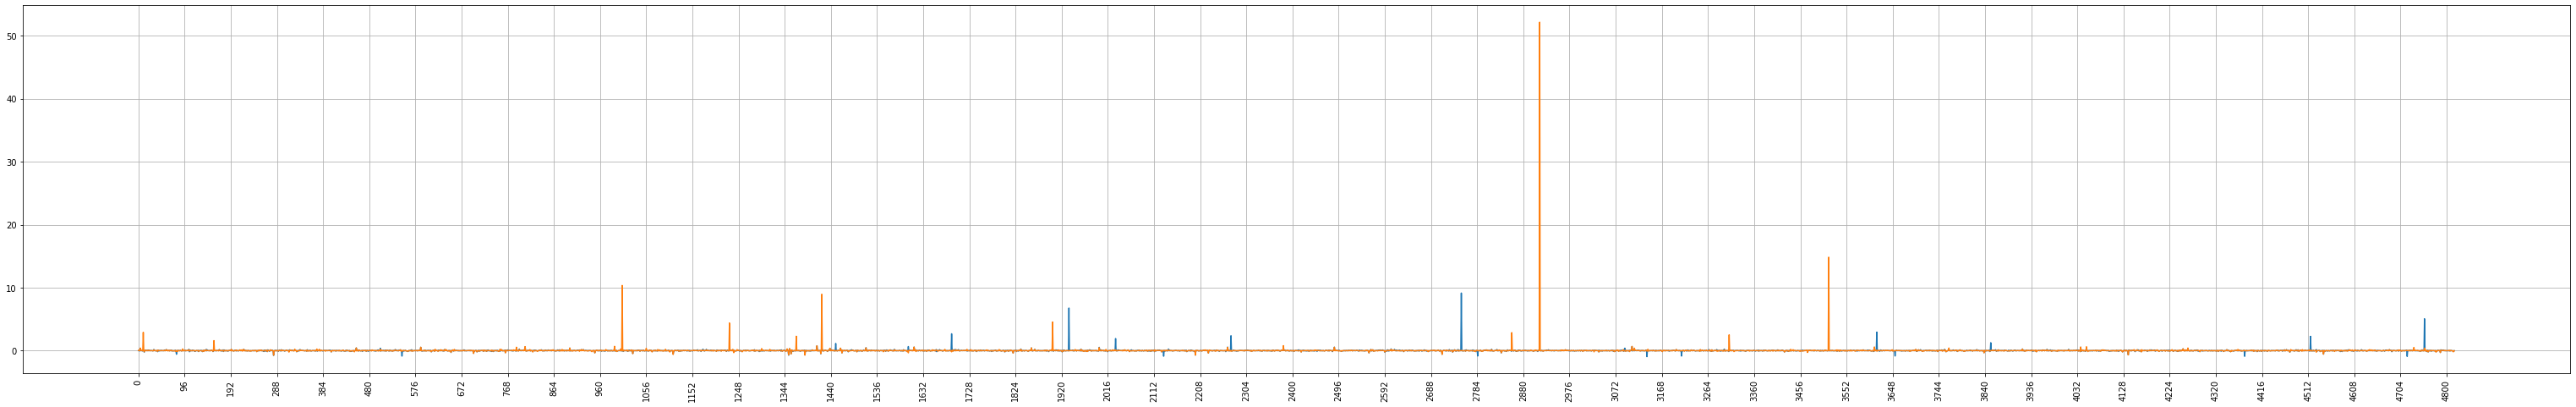

In [209]:
%%time
y_pred = model.predict(X_test)

print('MAE:', np.sum(np.abs(y_pred-y_test))/len(y_test))
print('MSE:', np.sum(np.abs(y_pred-y_test)**2)/len(y_test))

plt.figure(figsize=(54,8))
plt.plot(y_test)
plt.plot(y_pred)
plt.xticks(list(range(len(y_pred)))[::int(len(y_pred)/50)], rotation=90)
plt.grid()

In [210]:
increase_test = [ 1 if value > 0 else 0 for value in y_test ]
increase_pred = [ 1 if value > 0 else 0 for value in y_pred ]

m = confusion_matrix(increase_test, increase_pred)

print('Confusion matrix:')
print(m, '\n')

print('{:.2f}% True Positives'.format(100*m[1,1]/(m[1,1]+m[0,1])))
print('{:.2f}% True Negatives'.format(100*m[0,0]/(m[1,0]+m[0,0])))

# tn fp 
# fn tp

Confusion matrix:
[[1489  636]
 [ 499 2193]] 

77.52% True Positives
74.90% True Negatives


# Let's test it out on a random stock

251 datapoints returned by the API


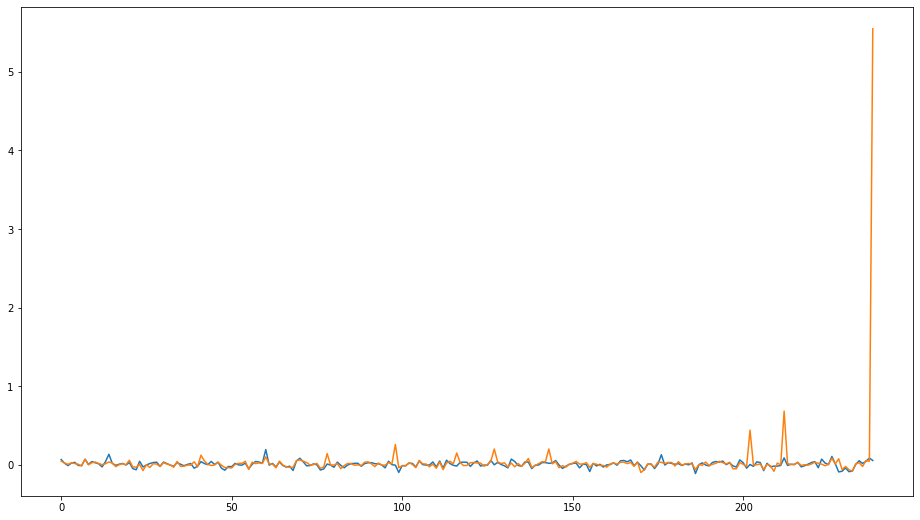

In [211]:
# the validation stock we 
# randomly chose from the df
code         = val_code

series       = get_oyak_data(code, 3)

dates, vals  = get_dates_vals(series)

all_features = get_cumulative_features(vals)

X, y = prepare_data(vals, all_features)

X, y = shuffle_data(X, y)

y_pred = model.predict(X)

plt.figure(figsize=(16,9))
plt.plot(y)
plt.plot(y_pred)

# lets see how well we predicted increases and decreases in the stock

In [212]:
increase_test = [ 1 if value > 0 else 0 for value in y ]
increase_pred = [ 1 if value > 0 else 0 for value in y_pred ]

m = confusion_matrix(increase_test, increase_pred)

print('Confusion matrix:')
print(m, '\n')

print('{:.2f}% True Positives'.format(100*m[1,1]/(m[1,1]+m[0,1])))
print('{:.2f}% True Negatives'.format(100*m[0,0]/(m[1,0]+m[0,0])))

# tn fp 
# fn tp

Confusion matrix:
[[ 72  34]
 [ 22 111]] 

76.55% True Positives
76.60% True Negatives


In [215]:
def simulate_trader(vals, y, verbose=False):
    
    prices = vals[(len(vals)-len(y)):]

    kapital = 100

    cash    = kapital
    stock   = 0
    
    threshold = 0
    commission_rate = 0 

    history = []

    for i, val in enumerate(y):

        if i == 0:
            continue

        todays_price = prices[i-1]

        # if next day will be - : sell
        if val < -threshold:
            
            cash  += (stock*todays_price)*(1-commission_rate)
            stock  = 0
        
        # if next day will be + : buy or hold
        elif val > threshold:
            
            stock += (cash/todays_price)*(1-commission_rate)
            cash   = 0
        
        else:
            pass

        
        if verbose:
            print(f'{i:3.0f} - cash: {cash:6.2f}\tstock: {stock:.2f}')
        history.append(cash + stock*todays_price)

    end_cash  = history[-1]

    days_past = (secs_to_date(series[:,0][-1])-secs_to_date(series[:,0][-len(y)])).days

    print(f'{100*((end_cash-kapital)/kapital):.2f}% return in {days_past} days')
    print()
    print(f'{kapital}TRY to {end_cash:.2f}TRY')
    
    # get fitting line
    x, y, slope = line_fit(
        range(len(history)), 
        history,
    )

    plt.figure()
    
    plt.plot(history, label='total value of assets')
    plt.plot(x,y, color='orange', label=f'fitting line w/ {slope:.2f} slope')
    
    plt.title('Balance for Trader Simulation')
    plt.xlabel('days')
    plt.ylabel('TRY')
    
    plt.legend()

27.75% return in 348 days

100TRY to 127.75TRY


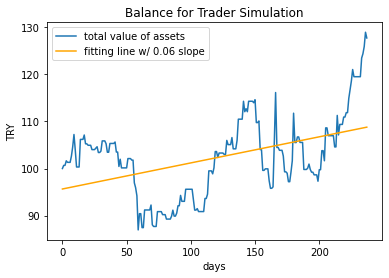

In [216]:
simulate_trader(vals, y)

## Let's try to predict the next timestep

In [28]:
def predict_next_timestep(codes):
    
    # to get the last date value
    series       = get_oyak_data(codes[0], 3, verbose=False)
    next_timestep = series[-1][0]+series[-1][0]-series[-2][0]
    tomorrow = dateify(next_timestep)

    for code in codes:
        
        series       = get_oyak_data(code, 3, verbose=False)
        
        sl = series.tolist()
        sl.append([next_timestep, 0])
        series = np.array(sl)

        dates, vals  = get_dates_vals(series)

        all_features = get_cumulative_features(vals)

        X, y = prepare_data(vals, all_features)

        new_pred = model.predict(X[-1:])

        print(f'{code} prediction for {tomorrow}: {"+" if new_pred[0]>0 else "-"}')


In [29]:
predict_next_timestep(
    [
        'TUKAS', 
        'GARAN', 
        'CRDFA', 
        'AKBNK', 
        'TCELL', 
        'ALARK', 
        'AFYON', 
        'VESTL', 
        'YKBNK', 
        'ZOREN', 
        'AEFES',
        'ULKER',
    ]
)

TUKAS prediction for 2020.12.02 03:00: +
GARAN prediction for 2020.12.02 03:00: -
CRDFA prediction for 2020.12.02 03:00: +
AKBNK prediction for 2020.12.02 03:00: +
TCELL prediction for 2020.12.02 03:00: -
ALARK prediction for 2020.12.02 03:00: -
AFYON prediction for 2020.12.02 03:00: +
VESTL prediction for 2020.12.02 03:00: -
YKBNK prediction for 2020.12.02 03:00: +
ZOREN prediction for 2020.12.02 03:00: -
AEFES prediction for 2020.12.02 03:00: +
ULKER prediction for 2020.12.02 03:00: -
